# VIX Markov Regime Model

An easy enhacement to this model is to incorporate a Markov Regime Switching model. In this case the Markov model is full-sample in-sample. Although this leads to obvious overfitting its still an initial test to see how the alphas behave given perfect information. It's also important to see how the returns drivers are set, specifically to managing tail risk. 

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\VIXCurveStrategies\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/VIXFuturesCurve/root/src")
from MarkovianStrats import MarkovianStrats
from BackgroundFunction import BackgroundFunctions

## Markov Returns

In [3]:
def get_rtn() -> pd.DataFrame: 
    
    df_out =  (MarkovianStrats().generate_signal_rtn().drop(
        columns = ["prob", "position"]).
        assign(group_var = lambda x: "Short: " + x.short_leg + " Markov Regression: " + x.markov.str.capitalize()).
        rename(columns = {"markov": "param"}))
    
    return df_out

df = get_rtn()

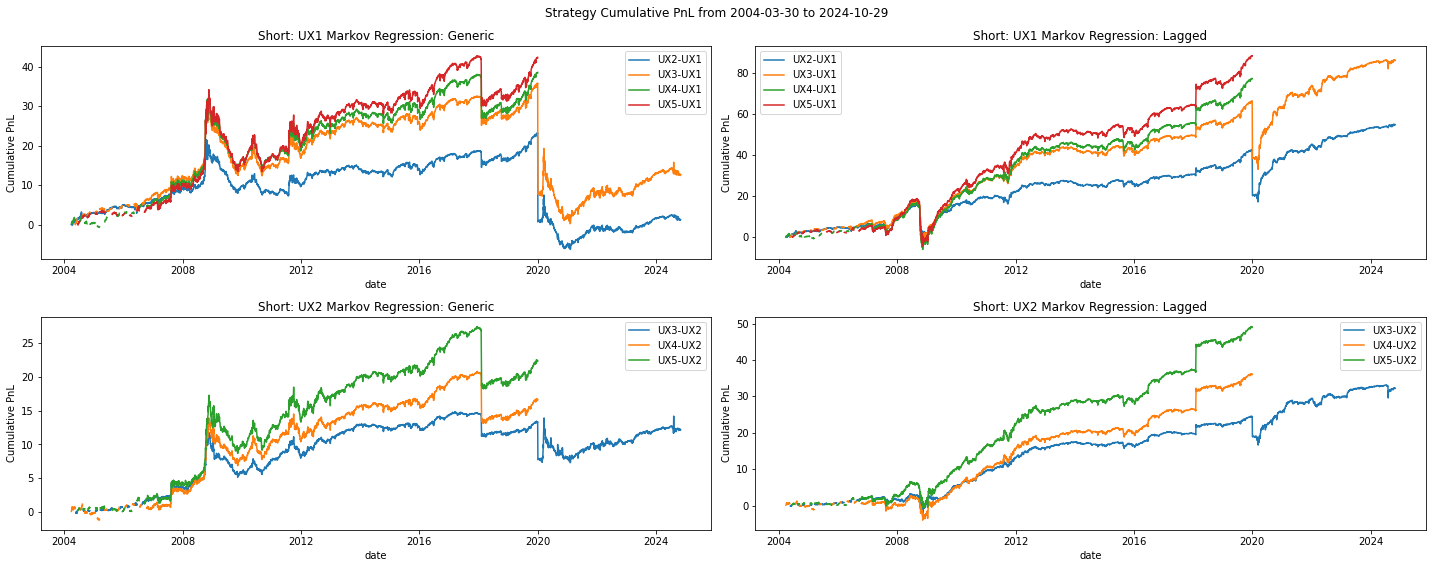

In [4]:
BackgroundFunctions().plot_backtest_rtn(df)

In [5]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_grouper = df[["strat", "short_leg"]].drop_duplicates()

    df_out = (df.drop(
        columns = ["group_var", "short_leg"]).
        melt(id_vars = ["date", "strat", "param"]).
        drop(columns = ["date"]).
        groupby(["strat", "param", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["strat", "param", "variable", "sharpe"]].
        pivot(index = ["strat", "param"], columns = "variable", values = "sharpe").
        reset_index().
        assign(param = lambda x: x.param.str.capitalize()).
        pivot(index = ["strat", "spread"], columns = "param", values = "signal_spread").
        reset_index().
        merge(right = df_grouper, how = "inner", on = ["strat"]).
        rename(columns = {"spread": "None"}).
        assign(strat = lambda x: x.strat.str.replace("-", "-\n")))
    
    return df_out

df_sharpe = get_sharpe(df)

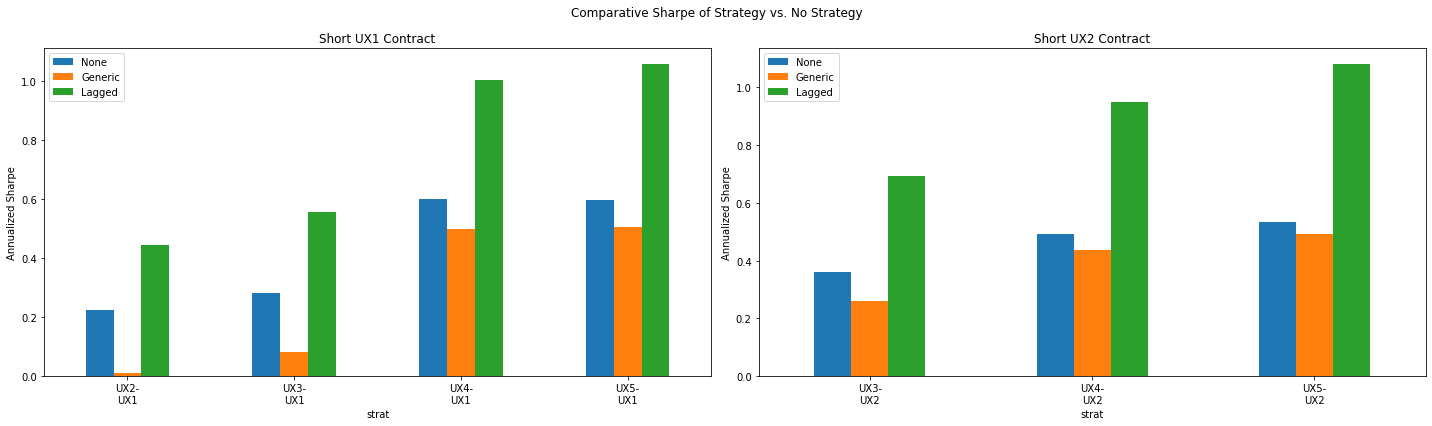

In [6]:
def plot_annualize_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.short_leg.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_sharpe.query(
            "short_leg == @group_var").
            drop(columns = ["short_leg"]).
            set_index("strat").
            plot(
                kind   = "bar",
                ax     = ax,
                ylabel = "Annualized Sharpe",
                title  = "Short {} Contract".format(group_var)))

        ax.tick_params(axis = "x", rotation = 0)

    fig.suptitle("Comparative Sharpe of Strategy vs. No Strategy")
    plt.tight_layout()
    
plot_annualize_sharpe(df_sharpe)

# Equal Risk Contribution Portfolio

In [7]:
def _erc_port(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_inv = (df[
        ["date", "strat", "signal_spread"]].
        pivot(index = "date", columns = "strat", values = "signal_spread").
        ewm(span = window, adjust = False).
        std().
        shift().
        reset_index().
        melt(id_vars = "date").
        dropna().
        assign(value = lambda x: 1 / x.value).
        rename(columns = {"value": "inv_vol"}))

    df_out = (df_inv.drop(
        columns = ["strat"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_inv, how = "inner", on = ["date"]).
        merge(right = df, how = "inner", on = ["date", "strat"]).
        assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_spread))

    return df_out


def get_erc(df: pd.DataFrame, window: int = 30) -> pd.DataFrame: 
    
    df_out = (df.groupby(
        "group_var").
        apply(_erc_port, window).
        reset_index(drop = True))

    return df_out

df_erc = get_erc(df)

In [8]:
def get_port(df_erc: pd.DataFrame) -> pd.DataFrame: 

    df_port = (df_erc[
        ["group_var", "date", "weighted_rtn"]].
        groupby(["date", "group_var"]).
        agg("sum").
        reset_index())

    return df_port

df_port = get_port(df_erc)

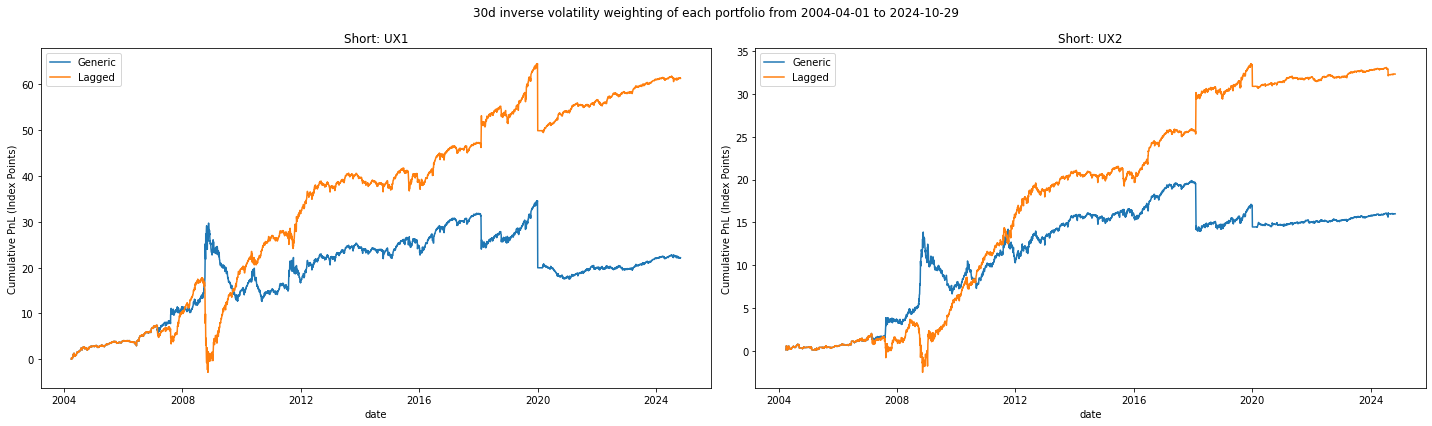

In [9]:
def plot_erc_port(df_port: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_port.assign(
        short_leg   = lambda x: x.group_var.str.split(" ").str[1],
        markov_kind = lambda x: x.group_var.str.split(" ").str[-1]))
    
    variables = df_tmp.short_leg.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_tmp.query(
            "short_leg == @variable")
            [["date", "markov_kind", "weighted_rtn"]].
            rename(columns = {"markov_kind": ""}).
            pivot(index = "date", columns = "", values = "weighted_rtn").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL (Index Points)",
                title  = "Short: " +  variable))
    
    fig.suptitle("30d inverse volatility weighting of each portfolio from {} to {}".format(
        df_tmp.date.min(),
        df_tmp.date.max()))
    
    plt.tight_layout()

plot_erc_port(df_port)

In [17]:
def get_erc_sharpe(df_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_port.drop(
        columns = ["date"]).
        groupby("group_var").
        agg(["mean", "std"])
        ["weighted_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = get_erc_sharpe(df_port)

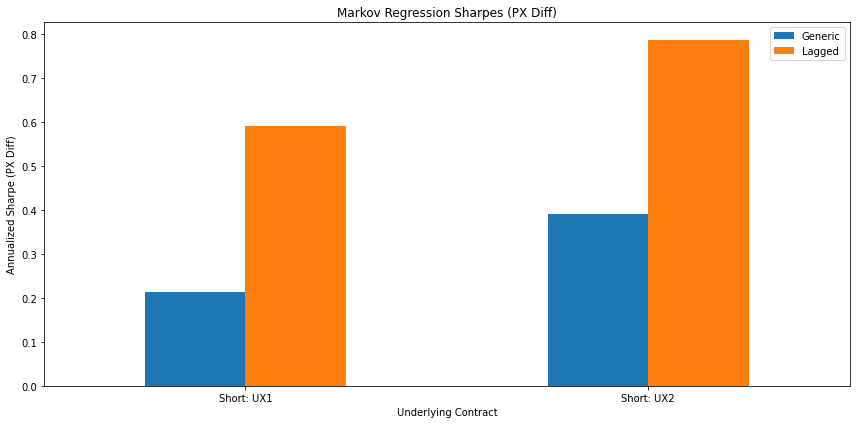

In [29]:
def plot_erc_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.assign(
        contract     = lambda x: x.group_var.str.split("Markov").str[0].str.strip(),
        regress_type = lambda x: x.group_var.str.split(":").str[-1].str.strip())
        [["contract", "regress_type", "sharpe"]].
        rename(columns = {"regress_type": ""}).
        pivot(index = "contract", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            rot     =  0,
            xlabel  = "Underlying Contract",
            figsize = (12,6),
            ylabel  = "Annualized Sharpe (PX Diff)",
            title   = "Markov Regression Sharpes (PX Diff)"))

    plt.tight_layout()
    
plot_erc_sharpe(df_sharpe)